In [1]:
#embedding_layer.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#27 July 2018
#
#train an embedding layer on the XO dataset

In [217]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 15
initial_id = 0

In [218]:
#start time
import time as tm
time_start = tm.time()

In [233]:
#generate training data
N_dots = 26700
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
train.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
26695,26695,-3.633001,4.166802,5.528195,2.287863,X,1.0,0.0,0.0
26696,26696,6.385672,3.275016,7.176526,0.473890,B,0.0,0.0,1.0
26697,26697,8.379639,-2.018357,8.619287,-0.236362,B,0.0,0.0,1.0
26698,26698,-8.297131,-1.254095,8.391373,-2.991580,B,0.0,0.0,1.0
26699,26699,-8.019130,-0.755836,8.054672,-3.047616,B,0.0,0.0,1.0


In [234]:
#rebalance in training data
print train.groupby('class')['id'].count()
df = train
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
train_balanced = df.sort_values('ran_num').reset_index(drop=True)
print train_balanced.groupby('class')['id'].count()
train_balanced.tail()

class
B    19857
O     3276
X     3567
Name: id, dtype: int64
class
B    3276
O    3276
X    3567
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score,ran_num
10114,532,-4.159629,-3.783246,5.622763,-2.403545,X,1.0,0.0,0.0,0.999464
10115,3289,3.242226,-2.460514,4.070154,-0.649171,O,0.0,1.0,0.0,0.999663
10116,25999,1.046170,-3.407234,3.564227,-1.272890,O,0.0,1.0,0.0,0.999758
10117,22205,1.210788,6.259352,6.375382,1.379720,B,0.0,0.0,1.0,0.999892
10118,20820,-5.076906,6.327340,8.112349,2.246984,X,1.0,0.0,0.0,0.999939


In [235]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
xx = train_balanced[x_cols].values
yy = train_balanced[y_cols].values
print 'xx.shape = ', xx.shape
print 'yy.shape = ', yy.shape
xx

xx.shape =  (10119, 2)
yy.shape =  (10119, 3)


array([[ 7.33207068, -1.02316177],
       [-3.81937305,  6.20072149],
       [ 3.41693847,  3.3443159 ],
       ..., 
       [ 1.04616986, -3.40723377],
       [ 1.21078813,  6.25935194],
       [-5.07690552,  6.32734045]])

In [244]:
#model parameters
N_input = len(x_cols)
N_output = len(y_cols)
vocab_size = 150
embedding_dimension = vocab_size

In [245]:
#rescale x so 0 <= x < vocab_size
x = xx - xx.min()
x /= x.max()
x *= vocab_size - 1
x = x.astype(int)
y = yy
print 'x.min() = ', x.min()
print 'x.max() = ', x.max()
x

x.min() =  0
x.max() =  149


array([[ 97,  73],
       [ 95,  53],
       [105,  45],
       ..., 
       [134,  68],
       [ 71,  78],
       [ 99, 114]])

In [246]:
# define the model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
model = Sequential()
model.add(Embedding(vocab_size, embedding_dimension, input_length=N_input))
model.add(Flatten())
model.add(Dense(N_output, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 2, 150)            22500     
_________________________________________________________________
flatten_23 (Flatten)         (None, 300)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 903       
Total params: 23,403
Trainable params: 23,403
Non-trainable params: 0
_________________________________________________________________


In [239]:
#fit model
N_epochs = 50
model.fit(x, y, epochs=N_epochs, verbose=0)
loss, accuracy = model.evaluate(x, y, verbose=0)
print 'training loss = ', loss
print 'training accuracy = ', accuracy

training loss =  0.484975821045
training accuracy =  0.741542313655


In [240]:
#generate sample of scaled X-O data
N_dots = 20000
xy = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
xx = xy[x_cols].values
yy = xy[y_cols].values
#rescale x so 0 <= x < vocab_size
x = xx - xx.min()
x /= x.max()
x *= vocab_size - 1
x = x.astype(int)
y = yy
print 'x.min(), x.max() = ', x.min(), x.max()
x

x.min(), x.max() =  0 49


array([[32, 24],
       [31, 17],
       [34, 14],
       ..., 
       [44, 22],
       [23, 25],
       [32, 37]])

In [241]:
#generate predicted class probabilities and their predicted X,O,B
y_pred = model.predict(x)
for idx in range(len(y_cols)):
    y_col = y_cols[idx]
    xy[y_col] = y_pred[:, idx]
idx = (xy.O_score > xy.X_score) & (xy.O_score > xy.B_score)
xy.loc[idx, 'class_pred'] = 'O'
idx = (xy.X_score > xy.B_score) & (xy.X_score > xy.O_score)
xy.loc[idx, 'class_pred'] = 'X'
idx = (xy.B_score > xy.O_score) & (xy.B_score > xy.X_score)
xy.loc[idx, 'class_pred'] = 'B'
loss, accuracy = model.evaluate(x, y, verbose=0)
print 'testing loss = ', loss
print 'testing accuracy = ', accuracy
xy.head()

testing loss =  0.451933817005
testing accuracy =  0.764533335495


,id,x,y,r,angle,class,X_score,O_score,B_score,class_pred
record,,,,,,,,,,
0,0,3.670821,-0.315774,3.684377,-0.085811,B,0.384959,4.151617e-01,0.169346,O
1,1,3.325490,-3.469159,4.805616,-0.806539,X,0.503800,2.622434e-01,0.226672,X
2,2,4.945118,-4.879347,6.947102,-0.778704,B,0.483983,1.145236e-02,0.666752,B
3,3,8.709276,2.242395,8.993321,0.251999,B,0.000017,2.077953e-07,0.999991,B
4,4,8.792519,1.316098,8.890473,0.148581,B,0.000015,2.654948e-07,0.999987,B


In [242]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

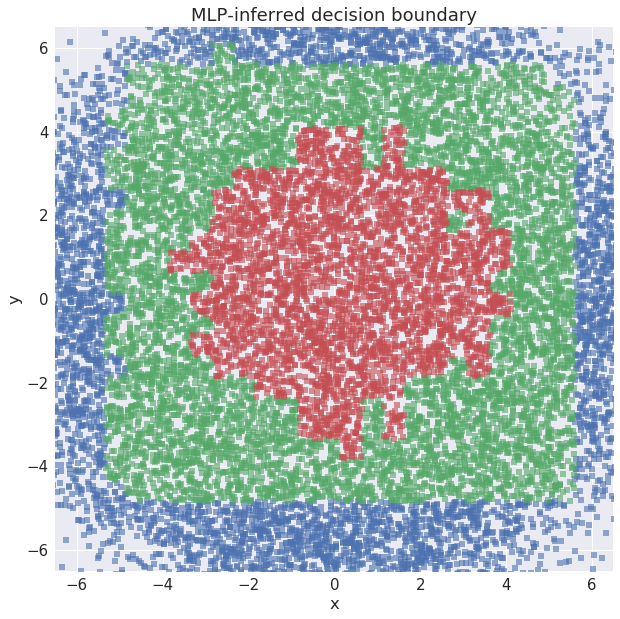

In [243]:
#scatterplot showing model's predicted decision boundaries
df = xy
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('MLP-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
#plt.savefig('figs/mlp_decision_boundary.png')

In [216]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  13.1504918536
